# Week 3 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [71]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition
from sklearn.ensemble import AdaBoostClassifier

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas as pd
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [75]:
noise1 = .4

dfTrain1, dfTest1 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
dfTrain1.name = "random_4/10"
dfTrain2, dfTest2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise1))
dfTrain2.name = "andsplit_4/10"
dfTrain3, dfTest3 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise1)) #Please try this one
dfTrain3.name = "xorsplit_4/10"
dfTrain4, dfTest4 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise1))
dfTrain4.name = "targetsplit_4/10"
dfTrain5, dfTest5 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise1))
dfTrain5.name = "multiBlobs_4/10"

noise2 = .1

dfTrain6, dfTest6 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
dfTrain6.name = "random_1/10"
dfTrain7, dfTest7 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise2))
dfTrain7.name = "andsplit_1/10"
dfTrain8, dfTest8 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise2)) #Please try this one
dfTrain8.name = "xorsplit_1/10"
dfTrain9, dfTest9 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise2))
dfTrain9.name = "targetsplit_1/10"
dfTrain10, dfTest10 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise2))
dfTrain10.name = "multiBlobs_1/10"

#noise3 = .8
#dfTrain5, dfTest5 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise3))

#dfTrain10, dfTest10 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise3))
#dfTrain10.name = "targetsplit_8/10"



In [76]:
training = [dfTrain1, dfTrain2, dfTrain3, dfTrain4, dfTrain5,
            dfTrain6, dfTrain7, dfTrain8, dfTrain9, dfTrain10]
testing = [dfTest1, dfTest2, dfTest3, dfTest4, dfTest5,
          dfTest6, dfTest7, dfTest8, dfTest9, dfTest10]

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

So, dfTrain has two columns, vect and category. 

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [79]:
#Bayes
clf1 = sklearn.naive_bayes.GaussianNB()

#Analogizes
clf2 = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
clf3 = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf4 = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
clf5 = sklearn.linear_model.LogisticRegression()

#Symbolists
clf6 = sklearn.tree.DecisionTreeClassifier()
clf7 = sklearn.ensemble.RandomForestClassifier()

#Connectionists
clf8 = sklearn.neural_network.MLPClassifier()

#Ensemble
clf9 = sklearn.ensemble.GradientBoostingClassifier()
clf10 = AdaBoostClassifier(n_estimators=100)


We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [6]:
clf1.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
clf2.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
clf3.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
clf4.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
clf5.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
clf6.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
clf7.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
clf8.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
clf9.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [8]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.485,0.516426,0.537634,0.528478,0.480769
1,0.485,0.516426,0.495327,0.488462,0.552083


This lets us look at which classes do better:

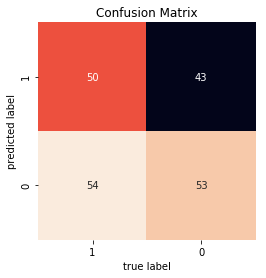

In [9]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

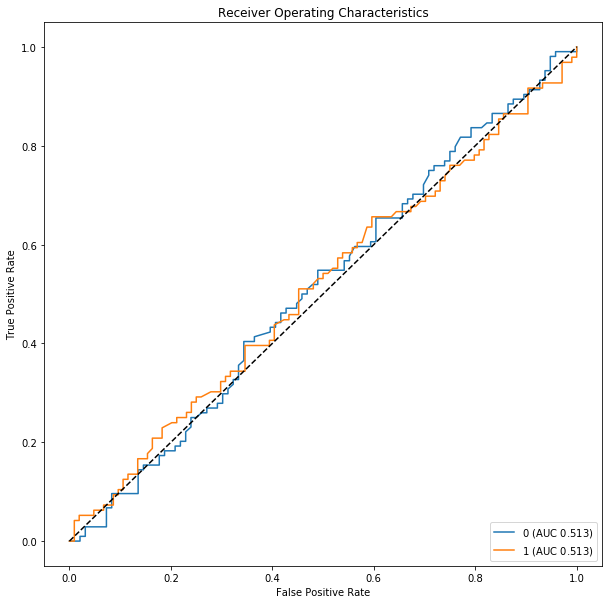

In [10]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


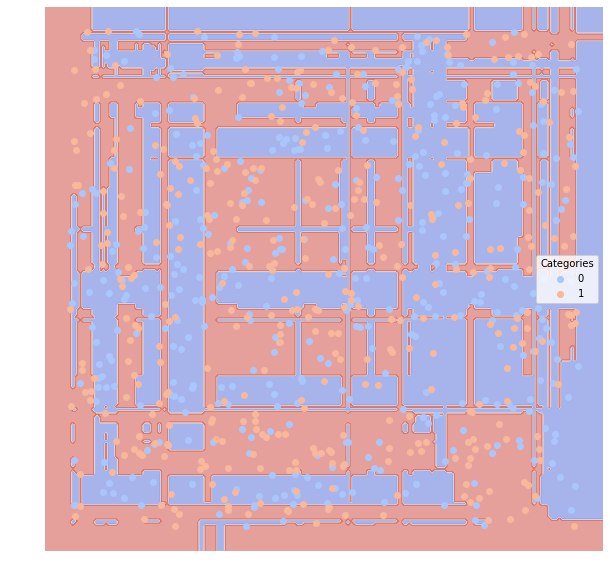

In [11]:
lucem_illud_2020.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [67]:
import sklearn.feature_extraction
import sklearn.datasets

In [85]:
Train1, Test1 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())
Train1.name = "Reddit"
Train2, Test2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
Train2.name = "NewsGroup"
Train3, Test3 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
Train3.name = "SenateSmall"
Train4, Test4 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
Train4.name = "SenateLarge"
Train5, Test5 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())
Train5.name = "Spam"

Loading Reddit data
Converting to vectors
Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors
Loading senate data
Converting to vectors
Loading senator: Kennedy
Loading senator: Kerry
Loading senator: Klobuchar
Loading senator: Kohl
Loading senator: Kyl
Converting to vectors
Loading Spam
Loading Ham
Converting to vectors


In [19]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [20]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GaussianNB(priors=None, var_smoothing=1e-09)

In [21]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates,0.153605,0.768593,0.731343,0.545126,0.612500
Tales From Tech Support,0.068966,0.873497,0.952381,0.782888,0.759494
Weeaboo Tales,0.203762,0.846129,0.570423,0.556118,0.952941
Relationships,0.169279,0.700027,0.723404,0.456470,0.453333


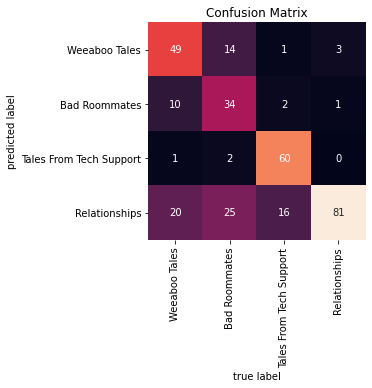

In [22]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

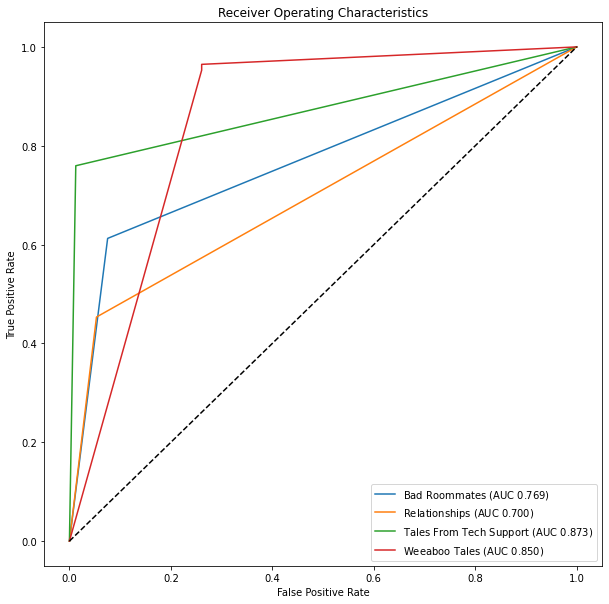

In [23]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

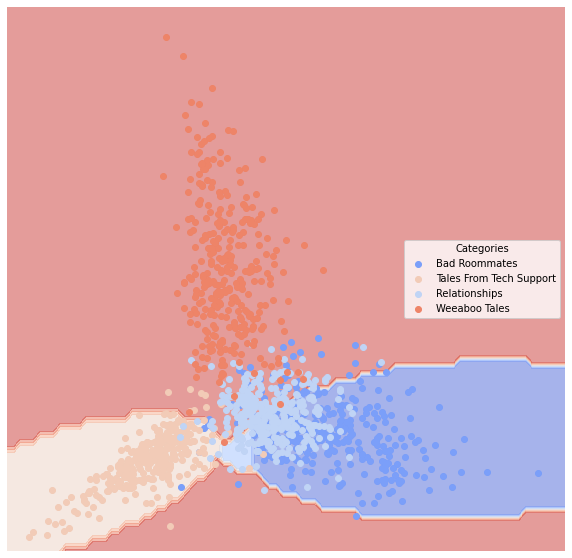

In [24]:
lucem_illud_2020.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [81]:
models = [clf1, clf2, clf3, clf4, clf5, clf6,
         clf7, clf8, clf9, clf10]

evaluations = pd.DataFrame({'Error_Rate':[], 'AUC':[],
                           'Precision':[], 'Average_Precision':[], 'Recall':[]})

for train, test in zip(training, testing):
    for model in models:
        model.fit(np.stack(train['vect'], axis=0), train['category'])
        stats = lucem_illud_2020.evaluateClassifier(model, test)
        stats.loc[:,'model'] = type(model).__name__
        stats.loc[:,'data'] = train.name
        evaluations = evaluations.append(stats)

C:\Users\pauli\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\pauli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pauli\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\pauli\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\pau

In [82]:
pd.set_option('display.max_rows', None)
evaluations

,AUC,Average_Precision,Error_Rate,Precision,Recall,data,model
0,0.499650,0.504825,0.500,0.504673,0.534653,random_4/10,GaussianNB
1,0.499650,0.494825,0.500,0.494624,0.464646,random_4/10,GaussianNB
0,0.544904,0.529407,0.455,0.549020,0.554455,random_4/10,SVC
1,0.544904,0.519528,0.455,0.540816,0.535354,random_4/10,SVC
0,0.535904,0.524506,0.465,0.548780,0.445545,random_4/10,SVC
1,0.535904,0.514053,0.465,0.525424,0.626263,random_4/10,SVC
0,0.480348,0.495586,0.520,0.483871,0.445545,random_4/10,KNeighborsClassifier
1,0.480348,0.485540,0.520,0.476636,0.515152,random_4/10,KNeighborsClassifier
0,0.545705,0.530254,0.455,0.558140,0.475248,random_4/10,LogisticRegression
1,0.545705,0.519701,0.455,0.535088,0.616162,random_4/10,LogisticRegression


These are the best performing classifiers in terms of average precision (ap) for each type of data:
* Random Data with high noise (.4): MLP Classifier, slightly better than random (ap=0.54)
* Linear split along one of two dimensions with high noise: Decision Tree (ap = 0.72)
* Split, opposite, on each dimension with high noise: MLP Classifier (ap = 0.76)
* One class is nested within the other in two dimensions with high noise: AdaBoostClassifier (ap=0.72)
* Five classes with bivariate Gaussians with high noise: All models performed equally well, and most of them were able to classify class # 2 better than the other classes
* Random Data with low noise (.1): GradientBoostingClassifier, slightly better than random (ap=0.54)
* Linear split along one of two dimensions with low noise: Random Forest (ap = 0.94)
* Split, opposite, on each dimension with low noise: Random Forest (ap = 0.96)
* One class is nested within the other in two dimensions with low noise: MLP Classifier (ap=0.94)
* Five classes with bivariate Gaussians with low noise: All models performed equally well, and most of them were able to classify at least two classes very well

The amount of noise in the data was a key determinant in precision with all models performing better on less noisy data. Additionally, non-parametric models such as decision trees, random forests, AdaBoost classifiers and MLP classifiers performed the best.

In [88]:
idx = evaluations.groupby(['data'])['Average_Precision'].transform(max) == evaluations['Average_Precision']
evaluations[idx]

,AUC,Average_Precision,Error_Rate,Precision,Recall,data,model
0,0.570957,0.546628,0.430,0.592593,0.475248,random_4/10,MLPClassifier
1,0.761404,0.722131,0.240,0.793814,0.733333,andsplit_4/10,DecisionTreeClassifier
1,0.800422,0.765567,0.200,0.825243,0.794393,xorsplit_4/10,MLPClassifier
1,0.788009,0.729300,0.210,0.823529,0.721649,targetsplit_4/10,AdaBoostClassifier
1,1.000000,1.000000,0.000,1.000000,1.000000,multiBlobs_4/10,GaussianNB
1,1.000000,1.000000,0.000,1.000000,1.000000,multiBlobs_4/10,SVC
1,1.000000,1.000000,0.000,1.000000,1.000000,multiBlobs_4/10,SVC
1,1.000000,1.000000,0.000,1.000000,1.000000,multiBlobs_4/10,KNeighborsClassifier
0,1.000000,1.000000,0.000,1.000000,1.000000,multiBlobs_4/10,LogisticRegression
1,1.000000,1.000000,0.000,1.000000,1.000000,multiBlobs_4/10,RandomForestClassifier


In [86]:
training2 = [Train1, Train2, Train3, Train4, Train5]
testing2 = [Test1, Test2, Test3, Test4, Test5]

In [87]:

evaluations2 = pd.DataFrame({'Error_Rate':[], 'AUC':[],
                           'Precision':[], 'Average_Precision':[], 'Recall':[]})

for train, test in zip(training2, testing2):
    for model in models:
        model.fit(np.stack(train['vect'], axis=0), train['category'])
        stats = lucem_illud_2020.evaluateClassifier(model, test)
        stats.loc[:,'model'] = type(model).__name__
        stats.loc[:,'data'] = train.name
        evaluations2 = evaluations2.append(stats)

C:\Users\pauli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pauli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pauli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pauli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pauli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: U

In [89]:
idx = evaluations2.groupby(['data'])['Average_Precision'].transform(max) == evaluations2['Average_Precision']
evaluations2[idx]

,AUC,Average_Precision,Error_Rate,Precision,Recall,data,model
Tales From Tech Support,1.000000,1.000000,0.000000,1.000000,1.000000,Reddit,MLPClassifier
comp.windows.x,0.963695,0.914781,0.027660,0.952381,0.944882,NewsGroup,MLPClassifier
Kerry,1.000000,1.000000,0.000000,1.000000,1.000000,SenateLarge,DecisionTreeClassifier
Kerry,1.000000,1.000000,0.000000,1.000000,1.000000,SenateLarge,GradientBoostingClassifier
Kohl,1.000000,1.000000,0.000000,1.000000,1.000000,SenateLarge,GradientBoostingClassifier
Kerry,1.000000,1.000000,0.000000,1.000000,1.000000,SenateLarge,AdaBoostClassifier
not spam,0.841303,0.947441,0.143275,0.963391,0.863558,Spam,GaussianNB


As seen above, the best performing classifiers for the real datasets are also those that are non-parametric such as the MLP, Decision Tree, Boost. However, for classifying spam, the Naive Bayes outperformed all other classifiers. 

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [90]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame. 

In [91]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [92]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Dec2007Obama192.txt,raw/Obama/10Dec2007Obama192.txt,Statement of Senator Barack Obama on Intern...,Obama
6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jan2007Obama472.txt,raw/Obama/10Jan2007Obama472.txt,Legislation to Increase Availability and Us...,Obama
7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jan2008Obama165.txt,raw/Obama/10Jan2008Obama165.txt,Obama Statement on the Flooding in East Cen...,Obama
8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jul2008Obama28.txt,raw/Obama/10Jul2008Obama28.txt,Obama Green Applaud House Passage of Bill ...,Obama
9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jul2008Obama29.txt,raw/Obama/10Jul2008Obama29.txt,Obama Joins Schumer and McCaskill to Call o...,Obama


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [93]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [94]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

Let's split the data into training data and testing data.

In [95]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [96]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud_2020.generateVecs()` will help with this but for now we are doing it the long way):

In [97]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents. 

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean? 

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1. 

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform. 

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [98]:
TFVects.shape

(1368, 11371)

We can save this in the dataframe to make things easier

In [99]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [100]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [101]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


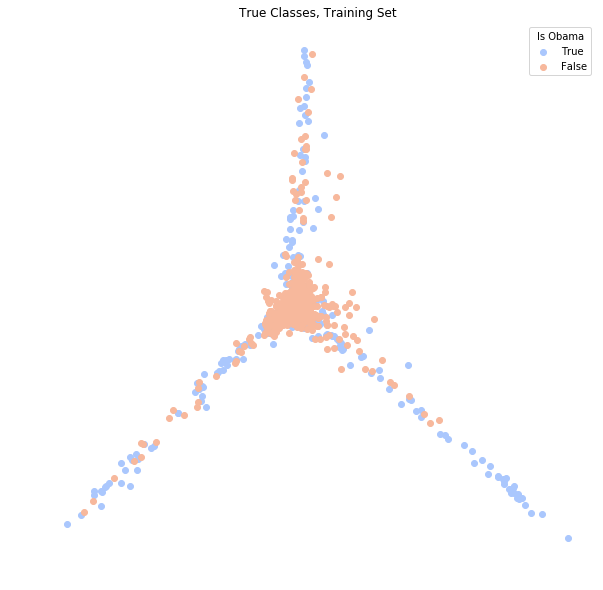

In [102]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

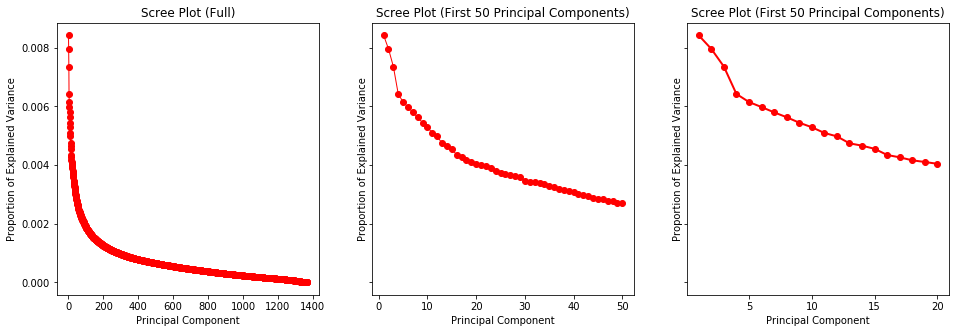

In [103]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [104]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [105]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [106]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6608187134502924

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [107]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6275659824046921

Slightly poorer. How about using more dimensions (40)?

In [108]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.75
Testing:
0.7126099706744868


Or still more (100)?

In [109]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8252923976608187
Testing:
0.7683284457478006


Or even more (200)!

In [110]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8669590643274854
Testing:
0.7859237536656891


This is becoming ridiculous (400)!

In [111]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9137426900584795
Testing:
0.8269794721407625


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [112]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9612573099415205


Train the model using training data, and then test it on the testing data.

In [113]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8328445747800587


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [114]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [115]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.952485380116959
Testing:
0.8709677419354839


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [116]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [117]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.8840579710144928

Recall:

In [118]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.8133333333333334

F1-measure:

In [119]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.8472222222222223

Let's take a look at how well our posterior distribution looks relative to the truth.

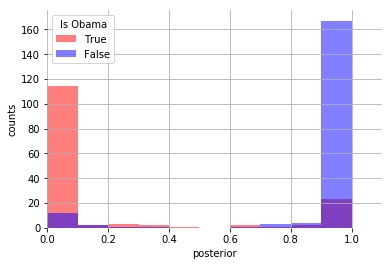

In [120]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [121]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Obama,Obama_log_prob,Clinton,Clinton_log_prob
0,welcomed,-2.243921,amy,-1.786426
1,fy,-2.303819,5566,-1.797121
2,urging,-2.316241,brundage,-1.852384
3,ground,-2.367535,dick,-1.887070
4,expected,-2.435588,monday,-1.935272
5,having,-2.435588,chicago,-2.095614
6,urban,-2.435588,reform,-2.186586
7,read,-2.449773,temporary,-2.269278
8,class,-2.464162,location,-2.304369
9,environment,-2.464162,oil,-2.322388


## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's explore this using the 20NG dataset, a scikit learn built in dataset which features 20 news categories.

In [122]:
from sklearn import datasets

In [123]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [124]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


Now we need to tokenize, and make a training and testing set:

In [126]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [127]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [128]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [135]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [136]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

...and save predictions to the dataframe:

In [137]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.8914683691236216


In [138]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
2063,comp.graphics,comp.graphics
223,talk.religion.misc,soc.religion.christian
1956,comp.graphics,comp.graphics
1784,comp.graphics,comp.graphics
832,soc.religion.christian,soc.religion.christian
2043,comp.graphics,comp.graphics
1481,sci.space,sci.space
762,soc.religion.christian,soc.religion.christian
80,talk.religion.misc,soc.religion.christian
328,talk.religion.misc,soc.religion.christian


Looks pretty good, lets examine the testing dataset:

In [139]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.7813953488372093


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud_2020`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

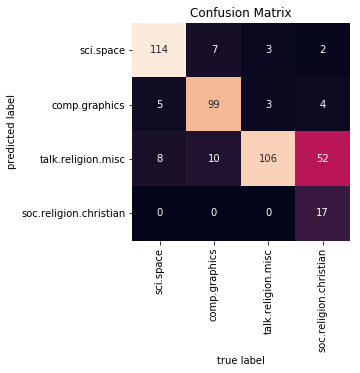

In [140]:
lucem_illud_2020.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [141]:
print(sklearn.metrics.precision_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #recall

0.8391134112064343
0.7813953488372093


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [142]:
lucem_illud_2020.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
talk.religion.misc,0.134884,0.613333,1.000000,0.361550,0.226667
soc.religion.christian,0.176744,0.863151,0.602273,0.583962,0.946429
sci.space,0.067442,0.907616,0.891892,0.800718,0.853448
comp.graphics,0.058140,0.929017,0.904762,0.842381,0.897638


We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

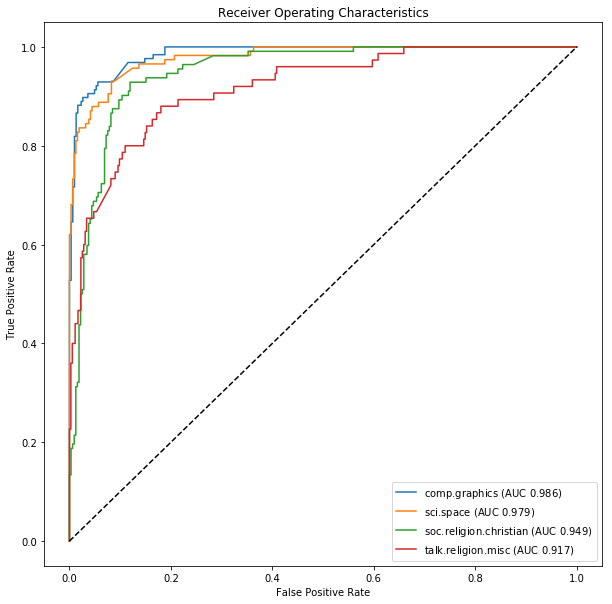

In [143]:
lucem_illud_2020.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

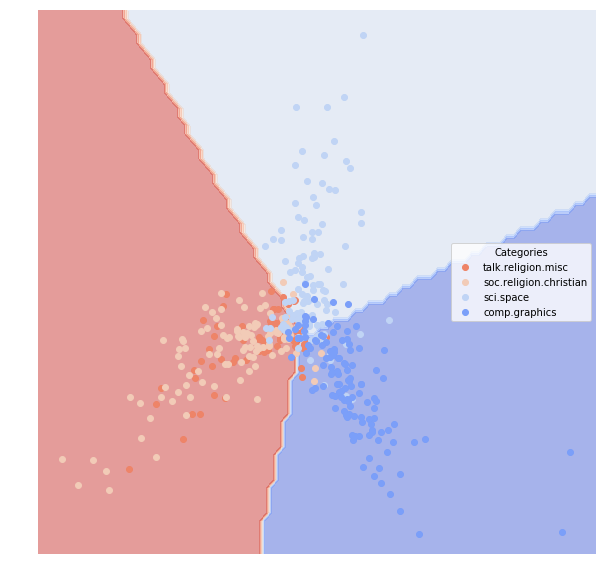

In [144]:
lucem_illud_2020.plotregions(MultinomialNB_ng, test_ng_df)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [219]:
pres_tweets = pd.read_csv('./sample_tweets.csv')
pres_tweets.head(3)

,created_at,screen_name,text
0,2020-04-29 17:55:00,JoeBiden,"Throughout our history, we have emerged from e..."
1,2020-04-29 16:05:00,JoeBiden,We owe a profound debt of gratitude to the hea...
2,2020-04-29 13:45:00,JoeBiden,I couldn't agree with @HillaryClinton more. We...


In [220]:
pres_tweets['category'] = [s == 'JoeBiden' for s in pres_tweets['screen_name']]
pres_tweets['tokenized_text'] = pres_tweets['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
pres_tweets['normalized_text'] = pres_tweets['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))
pres_tweets.head(3)

,created_at,screen_name,text,category,tokenized_text,normalized_text
0,2020-04-29 17:55:00,JoeBiden,"Throughout our history, we have emerged from e...",True,"[Throughout, our, history, we, have, emerged, ...","[history, emerge, crisis, strong]"
1,2020-04-29 16:05:00,JoeBiden,We owe a profound debt of gratitude to the hea...,True,"[We, owe, a, profound, debt, of, gratitude, to...","[owe, profound, debt, gratitude, health, care,..."
2,2020-04-29 13:45:00,JoeBiden,I couldn't agree with @HillaryClinton more. We...,True,"[I, could, n't, agree, with, @HillaryClinton, ...","[agree, @hillaryclinton, need, president, list..."


In [221]:
hold_frac = .2
train_tw, test_tw = lucem_illud_2020.trainTestSplit(pres_tweets, holdBackFraction=hold_frac)
print(len(train_tw))
print(len(test_tw))

960
240


In [222]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=10, min_df=1, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_tw['text'])
train_tw['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
TFVects.shape

(960, 4182)

In [223]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_tw['vect'], axis=0))
train_tw['pca'] = [r for r in reduced_data]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


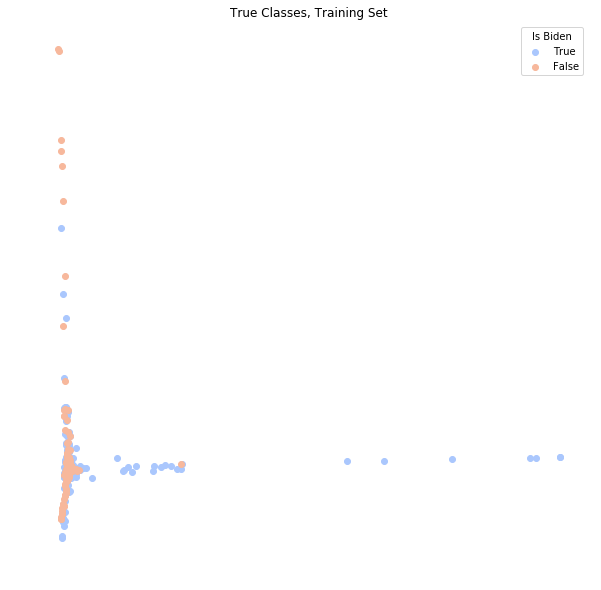

In [224]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Biden
a = np.stack(train_tw[train_tw['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Biden
a = np.stack(train_tw[train_tw['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Biden')
plt.title('True Classes, Training Set')
plt.show()

In [225]:
TFVects_test = TFVectorizer.transform(test_tw['text'])
test_tw['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

reduced_data_test = pca.transform(np.stack(test_tw['vect'], axis=0))
test_tw['pca'] = [r for r in reduced_data_test]

train_tw['pca_reduced_400'] = train_tw['pca'].apply(lambda x: x[:400])
test_tw['pca_reduced_400'] = test_tw['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_tw['pca_reduced_400'], axis=0), train_tw['category'])

print("Training:")
print(logistic.score(np.stack(train_tw['pca_reduced_400'], axis=0), train_tw['category']))
print("Testing:")
print(logistic.score(np.stack(test_tw['pca_reduced_400'], axis=0), test_tw['category']))
TFVects_test

Training:
0.9458333333333333
Testing:
0.8583333333333333


<240x4182 sparse matrix of type '<class 'numpy.float64'>'
	with 1352 stored elements in Compressed Sparse Row format>

In [226]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_tw['vect'], axis=0), train_tw['category'])
print("Training")
print(logistic_l1.score(np.stack(train_tw['vect'], axis=0), train_tw['category']))
print("Testing")
print(logistic_l1.score(np.stack(test_tw['vect'], axis=0), test_tw['category']))

Training
0.9979166666666667
Testing
0.85


In [227]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_tw['vect'], axis=0), train_tw['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [228]:
print("Training:")
print(naiveBayes.score(np.stack(train_tw['vect'], axis=0), train_tw['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_tw['vect'], axis=0), test_tw['category']))

Training:
0.934375
Testing:
0.7833333333333333


In [229]:
test_tw['nb_predict'] = naiveBayes.predict(np.stack(test_tw['vect'], axis=0))
test_tw['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_tw['vect'], axis=0))[:,0]

test_tw['lg_predict'] = logistic_l1.predict(np.stack(test_tw['vect'], axis=0))
test_tw['lg_predict_prob_true'] = logistic_l1.predict_proba(np.stack(test_tw['vect'], axis=0))[:,0]

In [230]:
lucem_illud_2020.metrics.evaluateClassifier(naiveBayes, test_tw)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.216667,0.802684,0.976471,0.817710,0.624060
True,0.216667,0.802684,0.677419,0.673091,0.981308


In [176]:
lucem_illud_2020.metrics.evaluateClassifier(logistic_l1, test_tw)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.116667,0.883186,0.872000,0.835521,0.900826
True,0.116667,0.883186,0.895652,0.841895,0.865546


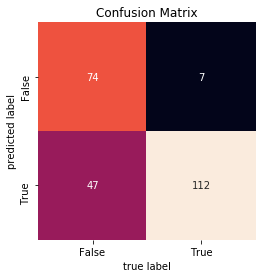

In [178]:
lucem_illud_2020.plotConfusionMatrix(naiveBayes, test_tw)

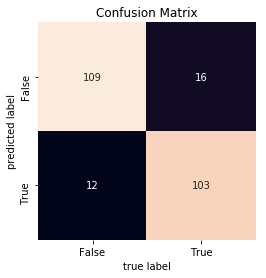

In [179]:
lucem_illud_2020.plotConfusionMatrix(logistic_l1, test_tw)

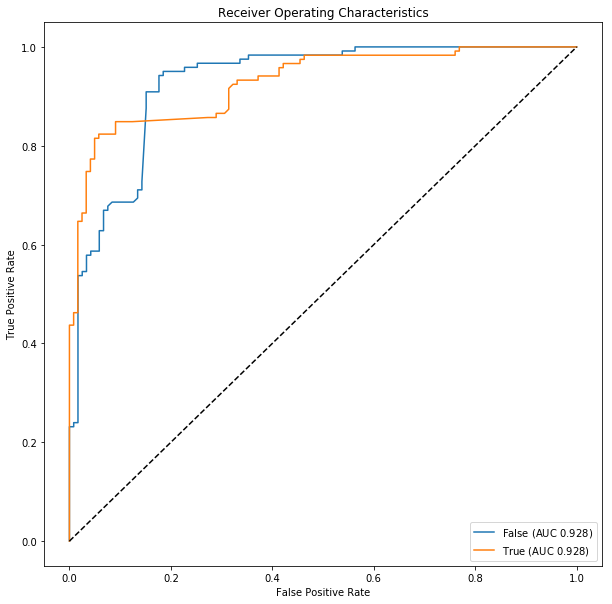

In [180]:
lucem_illud_2020.plotMultiROC(naiveBayes, test_tw)

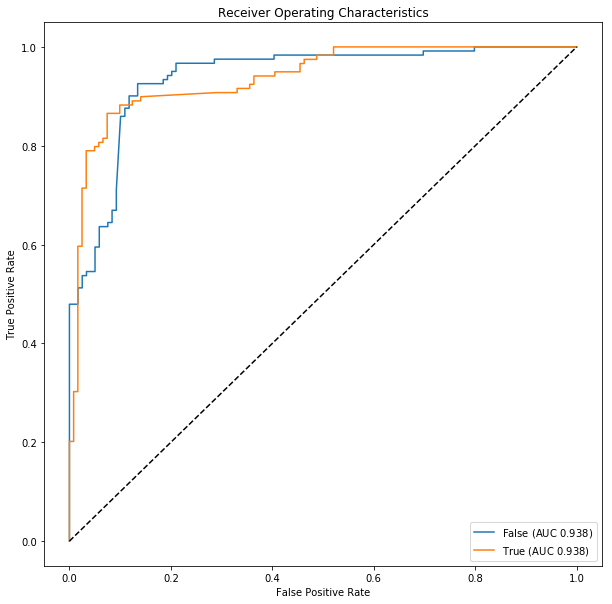

In [182]:
lucem_illud_2020.plotMultiROC(logistic_l1, test_tw)

In [231]:
new_tweets = pd.read_csv('./new_tweets.csv')
new_tweets['category'] = [s == 'JoeBiden' for s in new_tweets['screen_name']]
new_tweets['tokenized_text'] = new_tweets['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
new_tweets['normalized_text'] = new_tweets['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))
#TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=10, min_df=1, stop_words='english', norm='l2')
TFVects_new = TFVectorizer.transform(new_tweets['text'])
new_tweets['vect'] = [np.array(v).flatten() for v in TFVects_new.todense()]
new_tweets.head(3)

,created_at,screen_name,text,category,tokenized_text,normalized_text,vect
0,2020-04-29 19:36:00,JoeBiden,Wear a mask in public.\r\nRead your daily brie...,True,"[Wear, a, mask, in, public, Read, your, daily,...","[wear, mask, public, read, daily, briefing, li...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2020-02-29 16:05:00,JoeBiden,"Today, South Carolina has the chance to set ou...",True,"[Today, South, Carolina, has, the, chance, to,...","[today, south, carolina, chance, set, nation, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2020-02-29 14:15:00,JoeBiden,"Today’s the day, South Carolina! Confirm your ...",True,"[Today, ’s, the, day, South, Carolina, Confirm...","[today, day, south, carolina, confirm, poll, l...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [234]:
new_tweets['lg_predict'] = logistic_l1.predict(np.stack(new_tweets['vect'], axis=0))
new_tweets['lg_predict_prob_true'] = logistic_l1.predict_proba(np.stack(new_tweets['vect'], axis=0))[:,0]
new_tweets.head(3)

,created_at,screen_name,text,category,tokenized_text,normalized_text,vect,lg_predict,lg_predict_prob_true
0,2020-04-29 19:36:00,JoeBiden,Wear a mask in public.\r\nRead your daily brie...,True,"[Wear, a, mask, in, public, Read, your, daily,...","[wear, mask, public, read, daily, briefing, li...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,0.508212
1,2020-02-29 16:05:00,JoeBiden,"Today, South Carolina has the chance to set ou...",True,"[Today, South, Carolina, has, the, chance, to,...","[today, south, carolina, chance, set, nation, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,0.367551
2,2020-02-29 14:15:00,JoeBiden,"Today’s the day, South Carolina! Confirm your ...",True,"[Today, ’s, the, day, South, Carolina, Confirm...","[today, day, south, carolina, confirm, poll, l...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,0.338010


# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

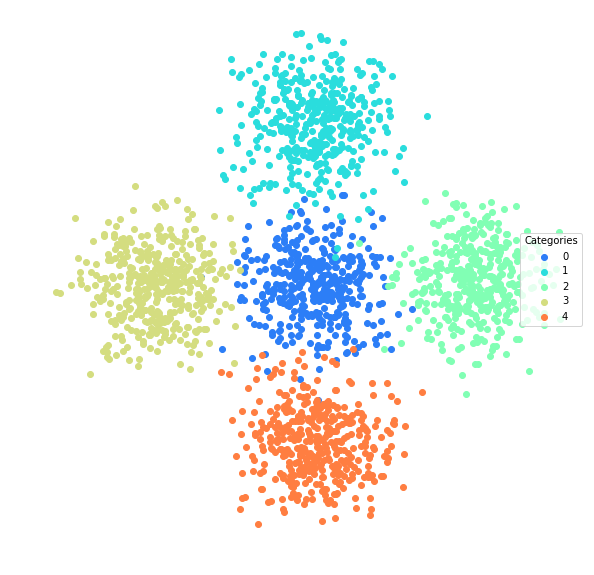

In [235]:
blobs_df = lucem_illud_2020.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud_2020.trainTestSplit(blobs_df)
lucem_illud_2020.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [236]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

To see what's going on visually with the classification: 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

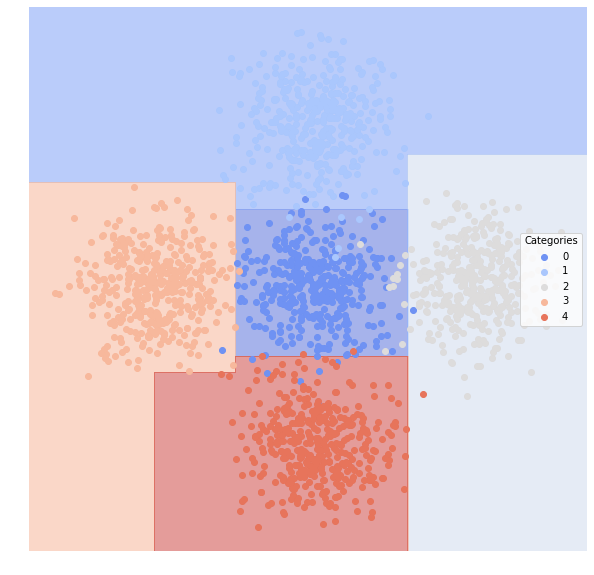

In [237]:
lucem_illud_2020.plotregions(clf_tree, df_exampleTree_train)

In [238]:
lucem_illud_2020.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.032,0.941768,0.950000,0.873415,0.896226
1,0.020,0.977389,0.938596,0.918998,0.972727
2,0.002,0.994845,1.000000,0.991691,0.989691
3,0.006,0.987164,0.988235,0.969253,0.976744
4,0.008,0.994987,0.961905,0.961905,1.000000


Lets look at accuracy:

In [239]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.966

What happens if we trim the tree?

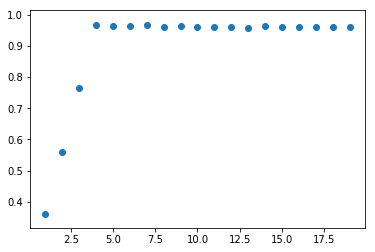

In [240]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [241]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [242]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=None, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

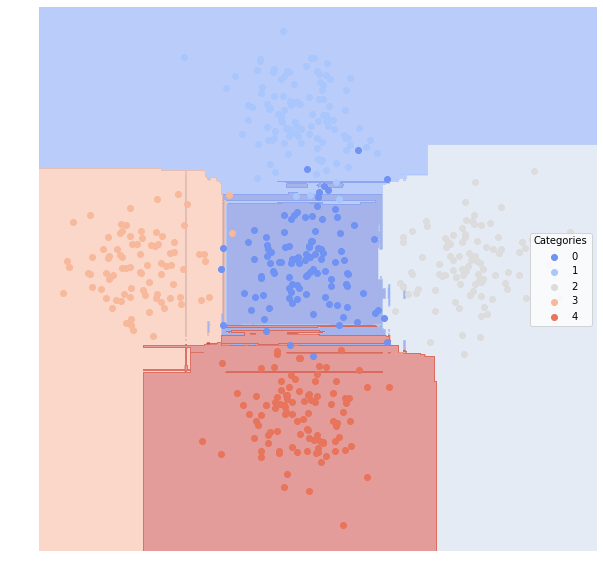

In [243]:
lucem_illud_2020.plotregions(bag, df_exampleTree_test)

In [244]:
lucem_illud_2020.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.034,0.937051,0.949495,0.866005,0.886792
1,0.022,0.972844,0.938053,0.911942,0.963636
2,0.002,0.998759,0.989796,0.989796,1.000000
3,0.006,0.987164,0.988235,0.969253,0.976744
4,0.008,0.994987,0.961905,0.961905,1.000000


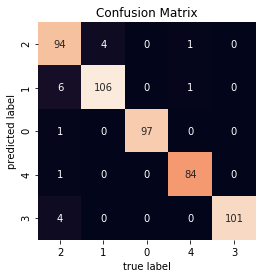

In [245]:
lucem_illud_2020.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

In [246]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_tw['vect'], axis =0), train_tw['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [247]:
lucem_illud_2020.evaluateClassifier(clf_tree, test_tw)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.533333,0.518797,1.000000,0.570927,0.037594
True,0.533333,0.518797,0.455319,0.455319,1.000000


In [249]:
sklearn.metrics.accuracy_score(test_tw['category'],clf_tree.predict(np.stack(test_tw['vect'], axis = 0)))

0.4666666666666667

In [250]:
sklearn.metrics.f1_score(test_tw['category'],clf_tree.predict(np.stack(test_tw['vect'], axis = 0)))

0.6257309941520467

In [252]:
rf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

rf_bag = sklearn.ensemble.BaggingClassifier(rf_tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [253]:
bag.fit(np.stack(train_tw['vect'], axis =0), train_tw['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=None, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [254]:
lucem_illud_2020.evaluateClassifier(bag, test_tw)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.3875,0.647635,0.934783,0.677223,0.323308
True,0.3875,0.647635,0.536082,0.533552,0.971963


In [255]:
sklearn.metrics.f1_score(test_tw['category'],bag.predict(np.stack(test_tw['vect'], axis = 0)))

0.6910299003322259

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


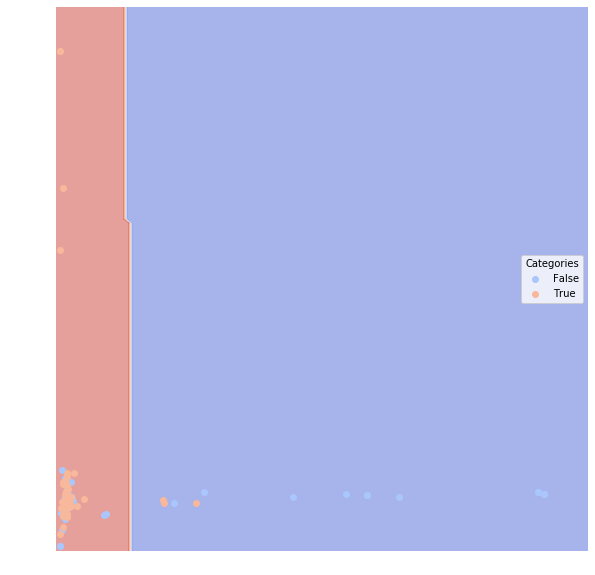

In [256]:
lucem_illud_2020.plotregions(bag, test_tw)

The first classifier which fits a decision tree to our tweet text data performs very poorly, almost as good as random predictions. The ensemble method which averages over various decision trees performs much better.

In [257]:
#fitting our model to new data
new_tweets['bag_pred'] = bag.predict(np.stack(new_tweets['vect'], axis=0))
new_tweets['bag_pred_prob_true'] = bag.predict_proba(np.stack(new_tweets['vect'], axis=0))[:,0]
new_tweets.head(3)

,created_at,screen_name,text,category,tokenized_text,normalized_text,vect,lg_predict,lg_predict_prob_true,bag_pred,bag_pred_prob_true
0,2020-04-29 19:36:00,JoeBiden,Wear a mask in public.\r\nRead your daily brie...,True,"[Wear, a, mask, in, public, Read, your, daily,...","[wear, mask, public, read, daily, briefing, li...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,0.508212,True,0.376774
1,2020-02-29 16:05:00,JoeBiden,"Today, South Carolina has the chance to set ou...",True,"[Today, South, Carolina, has, the, chance, to,...","[today, south, carolina, chance, set, nation, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,0.367551,True,0.467829
2,2020-02-29 14:15:00,JoeBiden,"Today’s the day, South Carolina! Confirm your ...",True,"[Today, ’s, the, day, South, Carolina, Confirm...","[today, day, south, carolina, confirm, poll, l...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,0.338010,True,0.467967


# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [258]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, well, ..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situational, admit,..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognize, holy, day, like, passover, ..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[be, sorry, read, commandment]"


Make a testing and training set:

In [259]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [260]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [261]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [262]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

In [263]:
lucem_illud_2020.evaluateClassifier(clf_knearest, train_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
talk.religion.misc,0.188624,0.743896,0.460784,0.356597,0.641638
soc.religion.christian,0.348230,0.537085,0.361644,0.308666,0.264529
sci.space,0.185723,0.739682,0.697436,0.517454,0.573840
comp.graphics,0.235055,0.734476,0.546429,0.453518,0.669584


And lets look at the testing data

In [264]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.29534883720930233


Let's produce another confusion matrix:

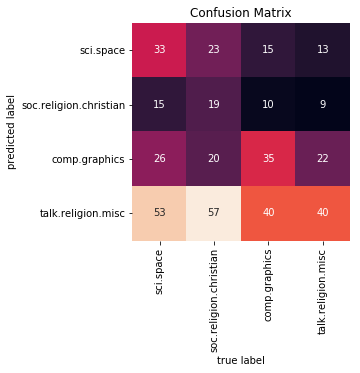

In [265]:
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud_2020.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [266]:
clf_knearest.fit(np.stack(train_tw['vect'], axis = 0), train_tw['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

In [268]:
print("Testing score:")
print(clf_knearest.score(np.stack(test_tw['vect'], axis=0), test_tw['category']))

Testing score:
0.8166666666666667


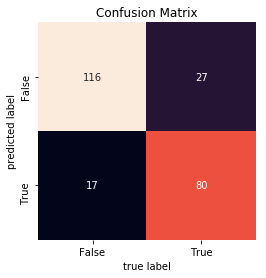

In [269]:
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_tw)

In [270]:
lucem_illud_2020.evaluateClassifier(clf_knearest, test_tw)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.183333,0.809922,0.811189,0.778336,0.872180
True,0.183333,0.809922,0.824742,0.729130,0.747664


In [272]:
sklearn.metrics.f1_score(test_tw['category'],clf_knearest.predict(np.stack(test_tw['vect'], axis = 0)))

0.7843137254901962

This classifier is loosely similar to the k-means cluster in the sense that it depends on the parameter k to estimate the class. However, while k-means is an unsupervised approach, k-nearest relies on labeled data that is similar (in some dimension) to the unlabeled data and uses similar observations to assign the appropiate class.

In [271]:
new_tweets['kn_predict'] = clf_knearest.predict(np.stack(new_tweets['vect'], axis=0))
new_tweets.head(3)

,created_at,screen_name,text,category,tokenized_text,normalized_text,vect,lg_predict,lg_predict_prob_true,bag_pred,bag_pred_prob_true,kn_predict
0,2020-04-29 19:36:00,JoeBiden,Wear a mask in public.\r\nRead your daily brie...,True,"[Wear, a, mask, in, public, Read, your, daily,...","[wear, mask, public, read, daily, briefing, li...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,0.508212,True,0.376774,True
1,2020-02-29 16:05:00,JoeBiden,"Today, South Carolina has the chance to set ou...",True,"[Today, South, Carolina, has, the, chance, to,...","[today, south, carolina, chance, set, nation, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,0.367551,True,0.467829,True
2,2020-02-29 14:15:00,JoeBiden,"Today’s the day, South Carolina! Confirm your ...",True,"[Today, ’s, the, day, South, Carolina, Confirm...","[today, day, south, carolina, confirm, poll, l...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,0.338010,True,0.467967,True


# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [273]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [274]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [275]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud_2020.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [276]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

...and consider the results:

In [277]:
lucem_illud_2020.evaluateClassifier(clf_svm, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.006270,0.990339,0.984615,0.972602,0.984615
Bad Roommates: Tales of Irritation,0.009404,0.982558,1.000000,0.974521,0.965116
Weeaboo Tales: stories about the extreme fans of japanese culture,0.003135,0.997863,0.988372,0.988372,1.000000
Tales From Tech Support,0.006270,0.995763,0.976471,0.976471,1.000000


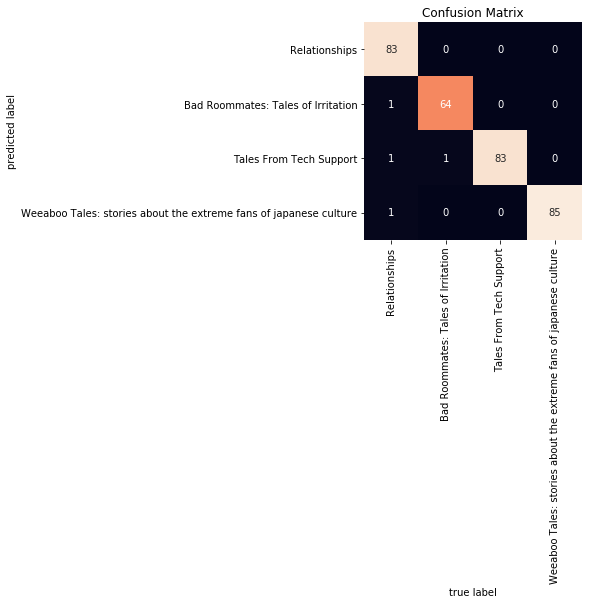

In [278]:
lucem_illud_2020.plotConfusionMatrix(clf_svm, test_redditDf)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

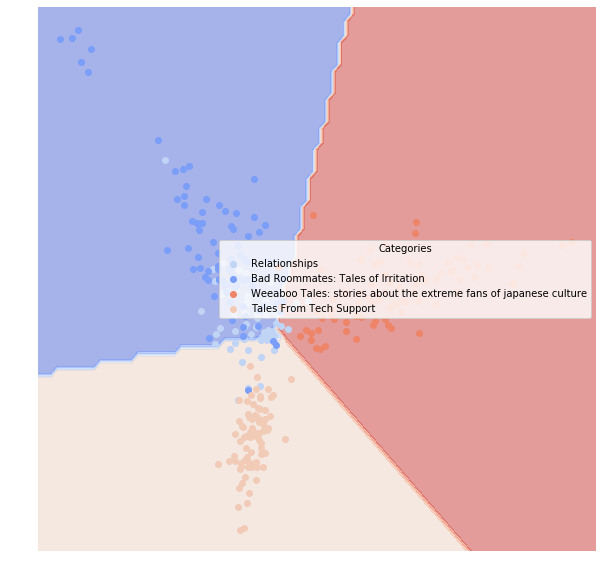

In [279]:
lucem_illud_2020.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [280]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [281]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.009404,0.988371,0.969697,0.957913,0.984615
Bad Roommates: Tales of Irritation,0.012539,0.976744,1.000000,0.966028,0.953488
Weeaboo Tales: stories about the extreme fans of japanese culture,0.006270,0.995726,0.977011,0.977011,1.000000
Tales From Tech Support,0.003135,0.997881,0.988095,0.988095,1.000000


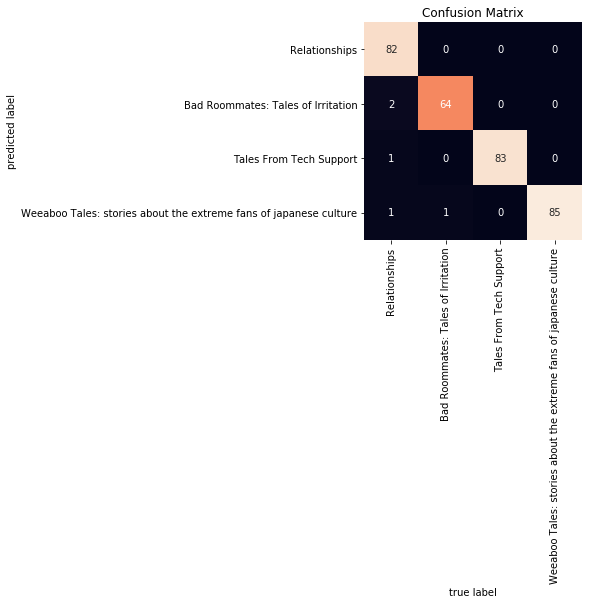

In [282]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_redditDf)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

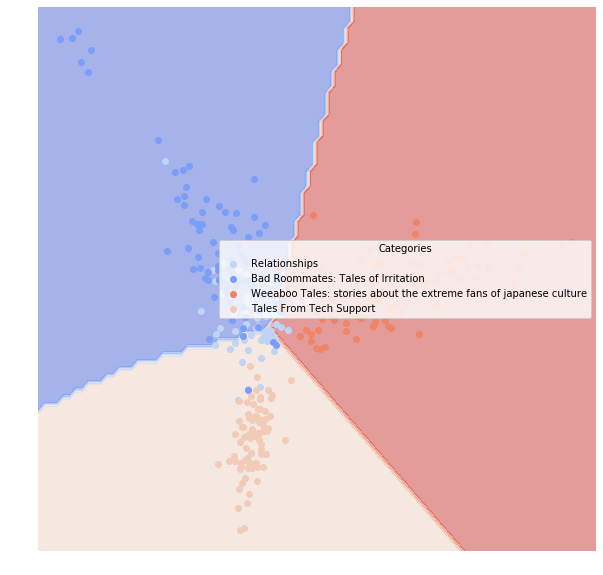

In [283]:
lucem_illud_2020.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

In [284]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_tw['vect'], axis=0), train_tw['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [285]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_tw)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.145833,0.851978,0.865672,0.825855,0.872180
True,0.145833,0.851978,0.839623,0.773378,0.831776


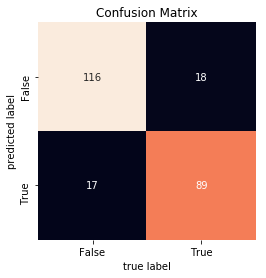

In [286]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_tw)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


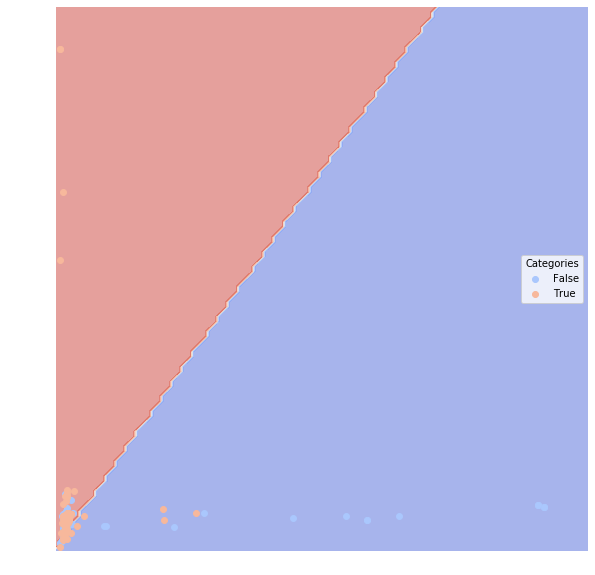

In [287]:
lucem_illud_2020.plotregions(clf_nn, test_tw)

The neural net classifier has been one of the most precise classfiers of our Twitte data. The only model that outperformed it is the logistic l1.